# Grouped By Graph Type CNN Model With Contamination Using Scanpaths - Conati Architecture With 3x3 Kernel

In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

In [ ]:
# Common settings
img_height = 288
img_width = 512
batch_size = 32

# Get the project root directory
# Try to find project root by looking for "Scanpaths" folder
current_dir = os.getcwd()
project_root = current_dir

# Navigate up to find project root (where "Scanpaths" exists)
for _ in range(3):  # Check up to 3 levels up
    if os.path.exists(os.path.join(current_dir, "Scanpaths")):
        project_root = current_dir
        break
    parent = os.path.dirname(current_dir)
    if parent == current_dir:  # Reached filesystem root
        break
    current_dir = parent

# Base dataset path: Scanpaths/organized_by_graph_type_contaminated (at project root)
base_dataset_path = os.path.join(project_root, "Scanpaths", "organized_by_graph_type_contaminated")

# Print path for verification
print(f"Project root: {project_root}")
print(f"Base dataset path: {base_dataset_path}")

In [3]:

# Function to create a model (based on the paper's CNN architecture, with original input size)
def create_model():
    model = models.Sequential([
        layers.Input(shape=(288, 512, 1)),  # Original resolution, grayscale

        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(6, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
# Train and evaluate one fold
def train_and_evaluate(dataset_name, fold, average_results):
    dataset_path = os.path.join(base_dataset_path, dataset_name)

    # Load datasets (RGB by default)
    train_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

    val_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

    # Convert RGB to grayscale
    def convert_to_grayscale(image, label):
        image = tf.image.rgb_to_grayscale(image)
        return image, label

    train_ds = train_ds.map(convert_to_grayscale)
    val_ds = val_ds.map(convert_to_grayscale)

    model = create_model()

    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[early_stop]
    )

    # Plot accuracy
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{dataset_name} - Training vs Validation Accuracy - Fold {fold + 1}')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{dataset_name} - Training vs Validation Loss - Fold {fold + 1}')
    plt.legend()
    plt.show()

    # Evaluate on validation set
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy().astype(int))
        y_pred.extend((preds > 0.5).astype(int).flatten())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Illiterate", "Literate"], yticklabels=["Illiterate", "Literate"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{dataset_name} - Confusion Matrix - Fold {fold + 1}')
    plt.show()

    # Track final epoch accuracy
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    average_results["train_accuracies"].append(final_train_acc)
    average_results["val_accuracies"].append(final_val_acc)

    print(f"Fold {fold + 1} Final Train Acc: {final_train_acc:.4f}, Final Val Acc: {final_val_acc:.4f}")



=== Running 5-fold CV for: bar ===
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.5105 - loss: 359.8892 - val_accuracy: 0.5677 - val_loss: 0.8437
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.7594 - loss: 0.5128 - val_accuracy: 0.5871 - val_loss: 0.6791
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9452 - loss: 0.2750 - val_accuracy: 0.6516 - val_loss: 1.0308
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9885 - loss: 0.0511 - val_accuracy: 0.6516 - val_loss: 0.9674
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0183 - val_accuracy: 0.6065 - val_loss: 1.5247
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.6065 - val_loss: 1.4249


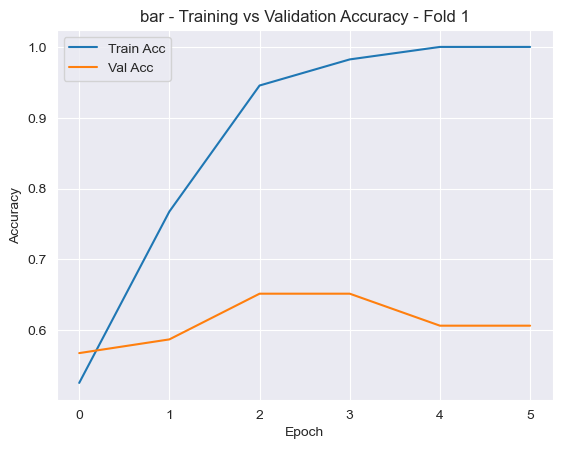

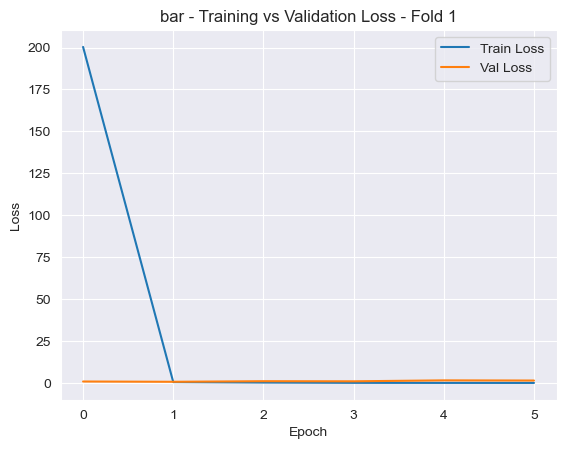

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


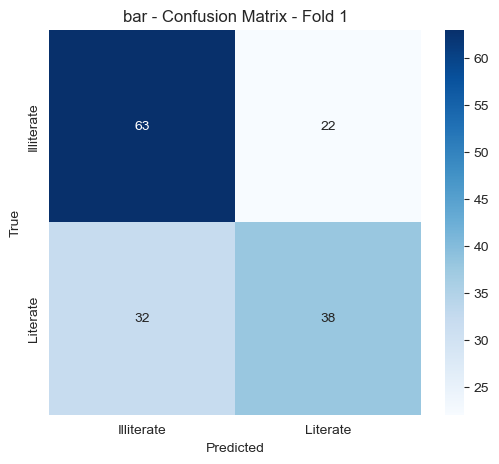

Fold 1 Final Train Acc: 1.0000, Final Val Acc: 0.6065
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.5139 - loss: 203.5961 - val_accuracy: 0.5484 - val_loss: 0.6933
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5571 - loss: 0.6939 - val_accuracy: 0.5484 - val_loss: 0.6926
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.5754 - loss: 0.6922 - val_accuracy: 0.5484 - val_loss: 0.6923
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.6090 - loss: 0.6911 - val_accuracy: 0.5484 - val_loss: 0.6919


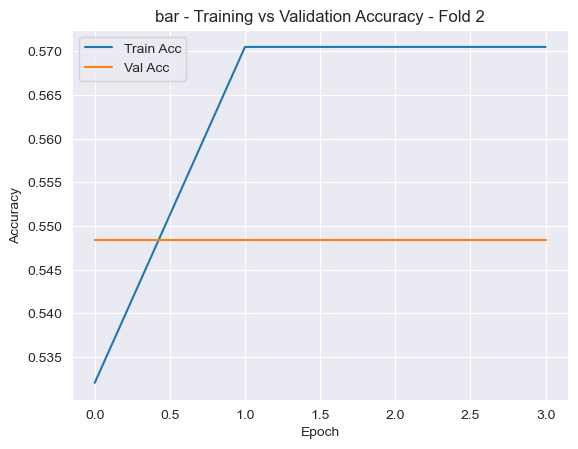

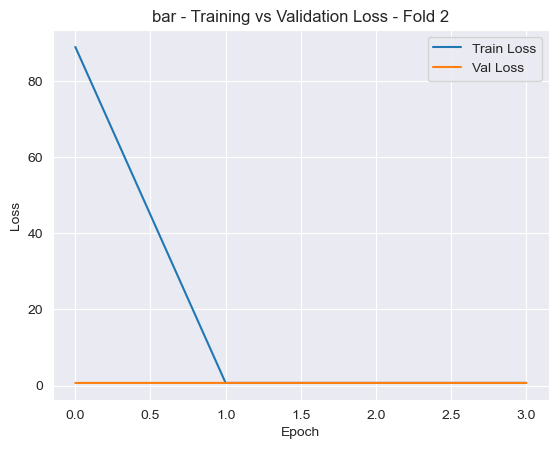

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


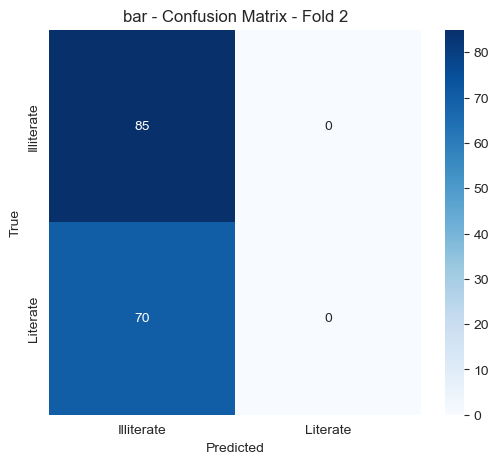

Fold 2 Final Train Acc: 0.5705, Final Val Acc: 0.5484
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.5345 - loss: 433.5867 - val_accuracy: 0.5484 - val_loss: 3.0626
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5008 - loss: 3.0526 - val_accuracy: 0.5677 - val_loss: 0.6932
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.8436 - loss: 0.5299 - val_accuracy: 0.5806 - val_loss: 0.7542
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9240 - loss: 0.2014 - val_accuracy: 0.6452 - val_loss: 0.9369
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9898 - loss: 0.0541 - val_accuracy: 0.6323 - val_loss: 1.5565
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.6387 - val_loss: 1.9190
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━

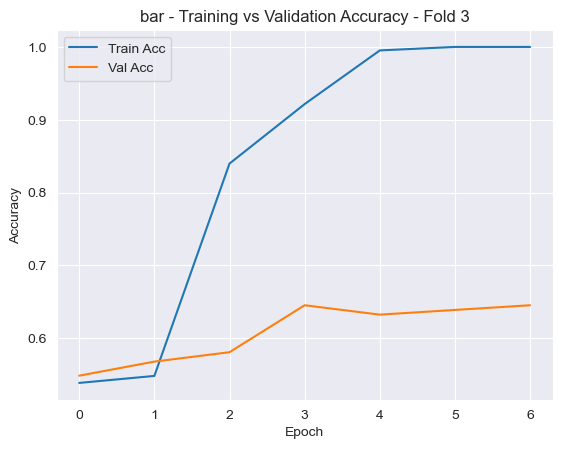

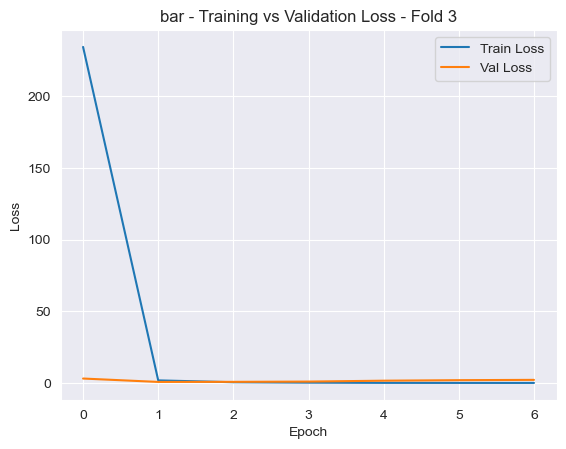

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


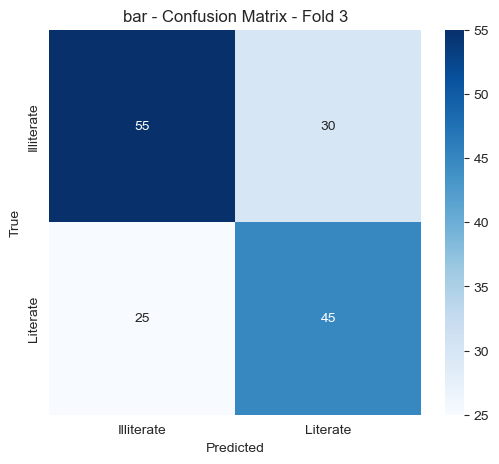

Fold 3 Final Train Acc: 1.0000, Final Val Acc: 0.6452
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.5129 - loss: 323.2673 - val_accuracy: 0.5484 - val_loss: 1.4157
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.5102 - loss: 1.4957 - val_accuracy: 0.6258 - val_loss: 0.6793
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.7699 - loss: 0.6122 - val_accuracy: 0.6387 - val_loss: 0.6540
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.8535 - loss: 0.4050 - val_accuracy: 0.6968 - val_loss: 0.6232
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9572 - loss: 0.1873 - val_accuracy: 0.6581 - val_loss: 0.7971
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9835 - loss: 0.0845 - val_accuracy: 0.6710 - val_loss: 0.8636
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━

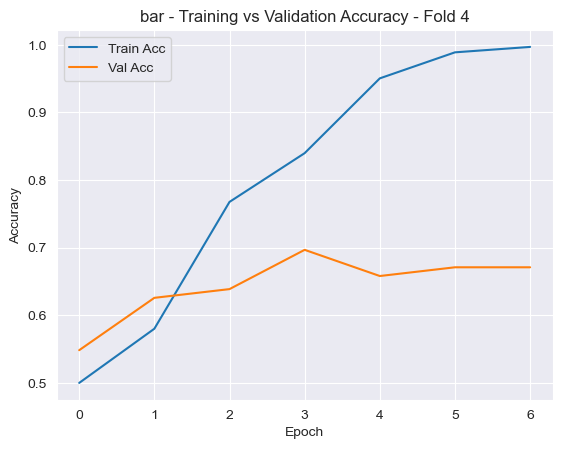

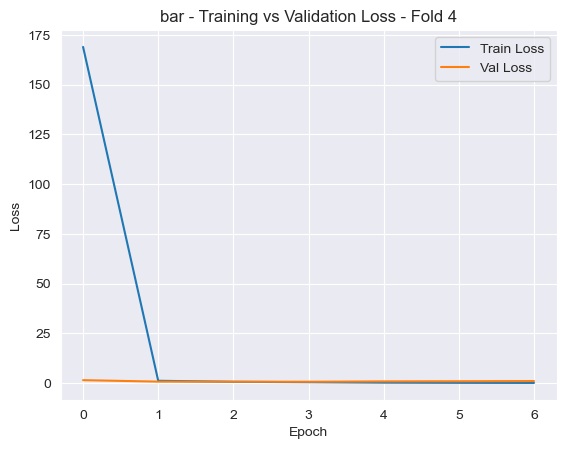

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


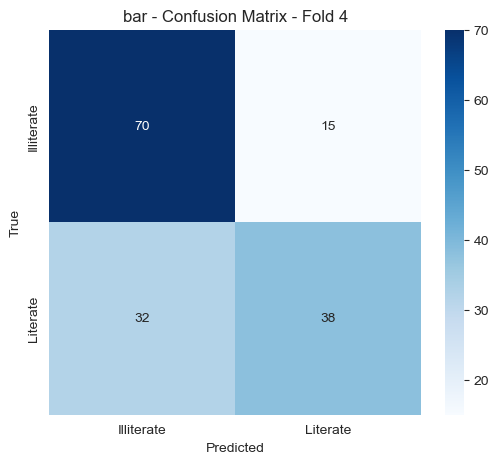

Fold 4 Final Train Acc: 0.9968, Final Val Acc: 0.6710
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.5163 - loss: 103.4752 - val_accuracy: 0.5484 - val_loss: 0.7264
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.6591 - loss: 0.6117 - val_accuracy: 0.5097 - val_loss: 0.7066
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.8797 - loss: 0.3837 - val_accuracy: 0.5613 - val_loss: 0.7872
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9710 - loss: 0.1270 - val_accuracy: 0.6065 - val_loss: 0.9637
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9991 - loss: 0.0460 - val_accuracy: 0.6000 - val_loss: 1.7257
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9930 - loss: 0.0107 - val_accuracy: 0.5871 - val_loss: 1.7914
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━

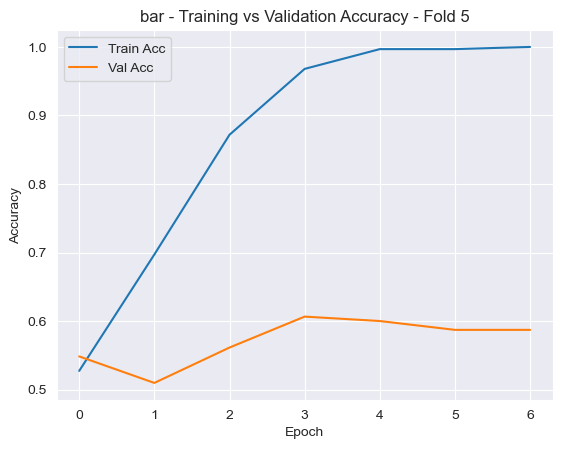

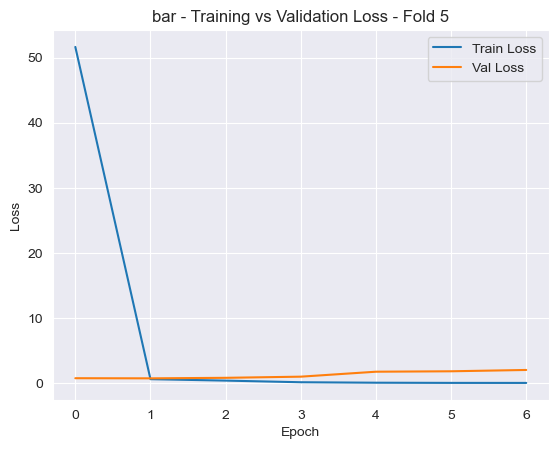

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


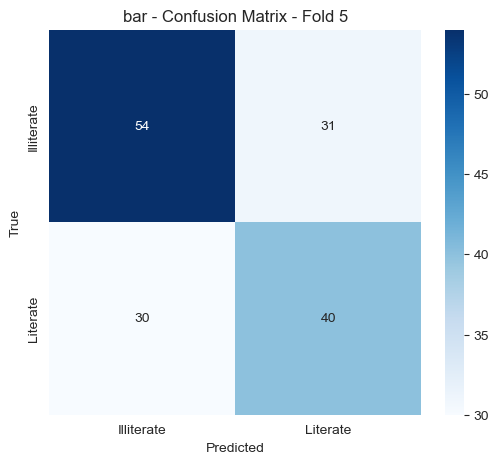

Fold 5 Final Train Acc: 1.0000, Final Val Acc: 0.5871

=== Running 5-fold CV for: line ===
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.4969 - loss: 641.8877 - val_accuracy: 0.7193 - val_loss: 0.6420
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.6916 - loss: 0.6615 - val_accuracy: 0.7105 - val_loss: 0.5823
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.8158 - loss: 0.4703 - val_accuracy: 0.7895 - val_loss: 0.4880
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9257 - loss: 0.1944 - val_accuracy: 0.7982 - val_loss: 0.6022
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9694 - loss: 0.1013 - val_accuracy: 0.7982 - val_loss: 0.5042
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9963 - loss: 0.0338 - val_accuracy: 0.8246 - val_loss: 0.51

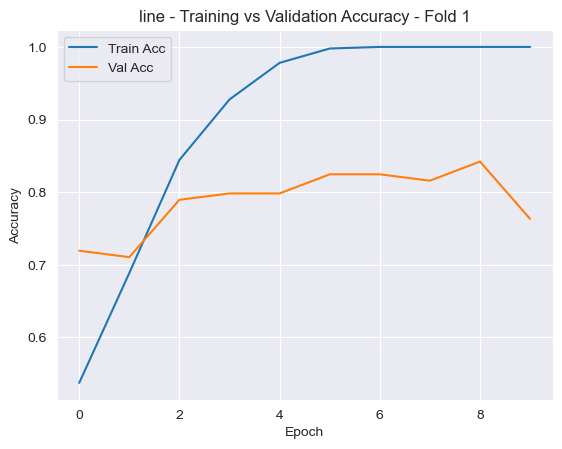

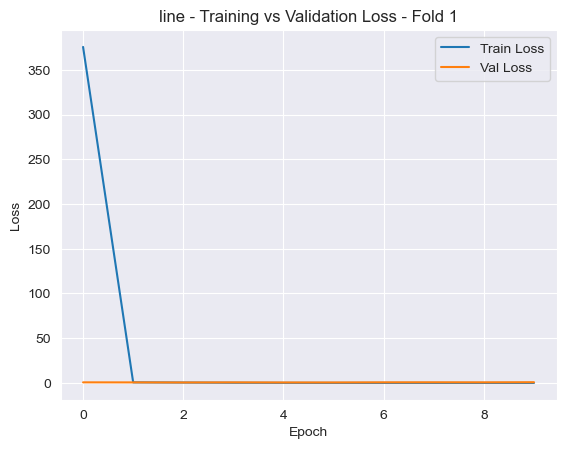

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


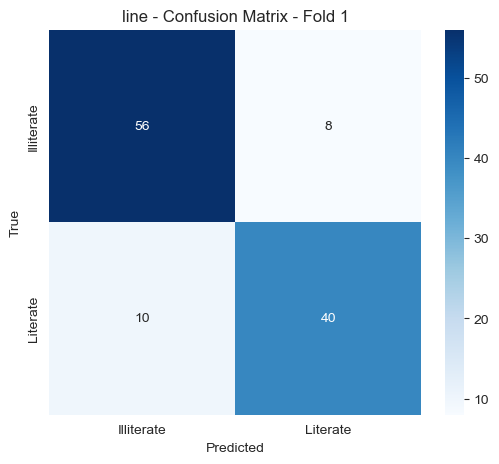

Fold 1 Final Train Acc: 1.0000, Final Val Acc: 0.7632
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.4760 - loss: 663.4195 - val_accuracy: 0.4386 - val_loss: 0.6978
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.4415 - loss: 3.2092 - val_accuracy: 0.5614 - val_loss: 0.6931
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.5469 - loss: 0.6932 - val_accuracy: 0.5614 - val_loss: 0.6928
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.5540 - loss: 0.6928 - val_accuracy: 0.5614 - val_loss: 0.6925
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5452 - loss: 0.9390 - val_accuracy: 0.5614 - val_loss: 0.6923


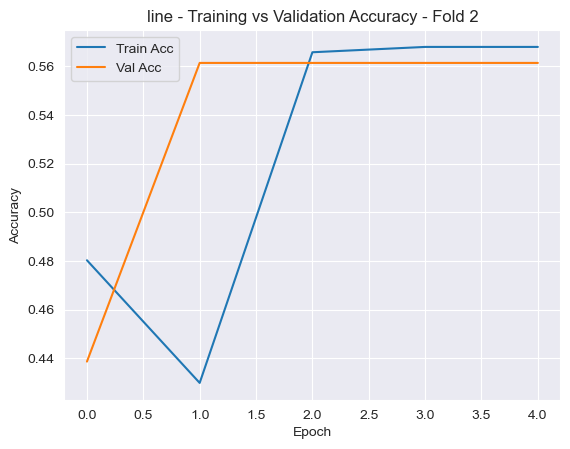

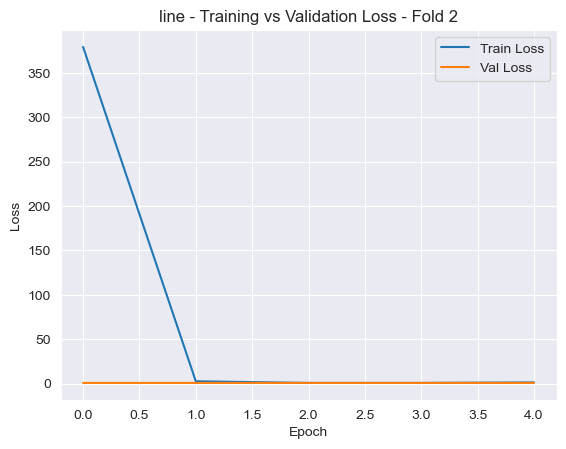

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


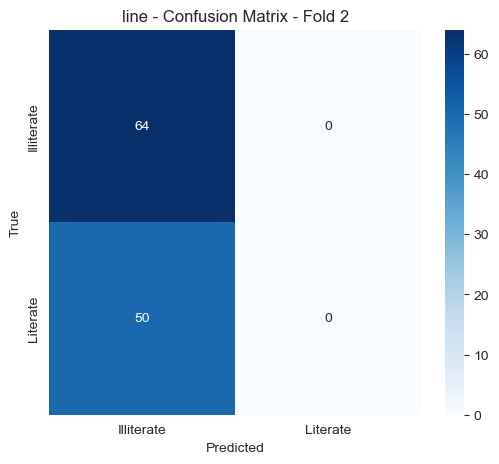

Fold 2 Final Train Acc: 0.5680, Final Val Acc: 0.5614
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.5694 - loss: 222.5644 - val_accuracy: 0.5614 - val_loss: 0.6901
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5176 - loss: 3.5277 - val_accuracy: 0.5702 - val_loss: 0.6934
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5165 - loss: 1.7779 - val_accuracy: 0.5614 - val_loss: 0.6920
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5522 - loss: 1.1009 - val_accuracy: 0.5614 - val_loss: 1.2035
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5414 - loss: 1.4100 - val_accuracy: 0.5088 - val_loss: 0.6869


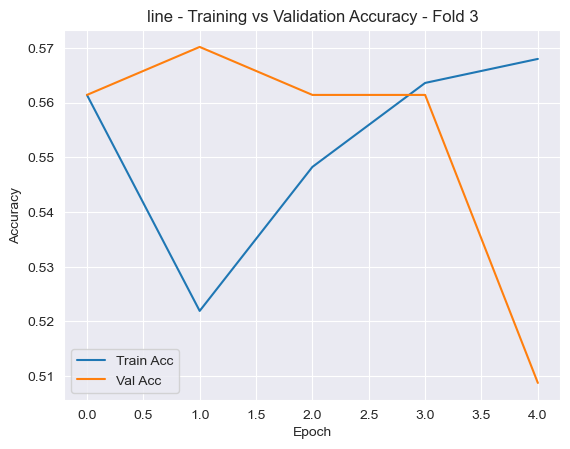

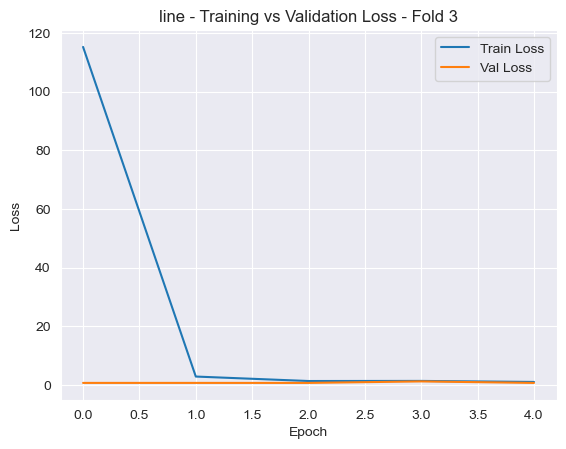

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


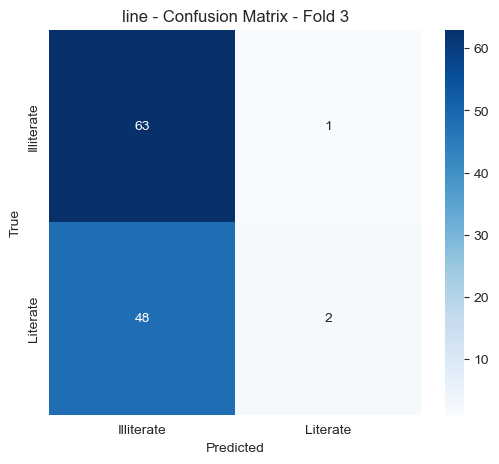

Fold 3 Final Train Acc: 0.5680, Final Val Acc: 0.5088
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.5651 - loss: 587.6459 - val_accuracy: 0.5614 - val_loss: 55.8569
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.5535 - loss: 19.7744 - val_accuracy: 0.5614 - val_loss: 0.6928
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5483 - loss: 1.8031 - val_accuracy: 0.5614 - val_loss: 0.6927
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.5540 - loss: 0.6927 - val_accuracy: 0.5614 - val_loss: 0.6925


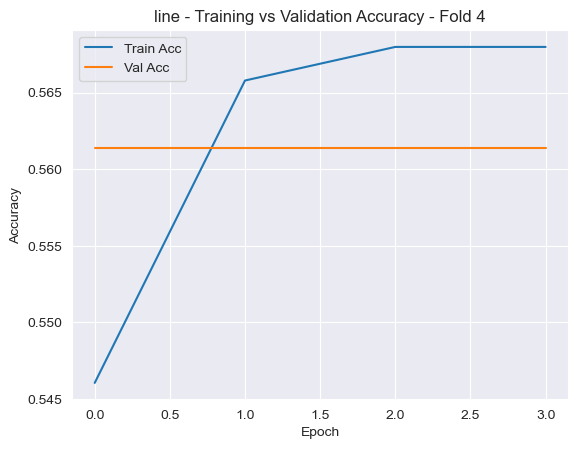

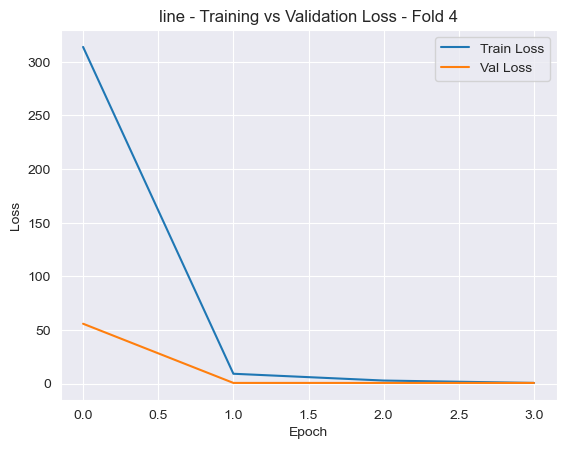

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


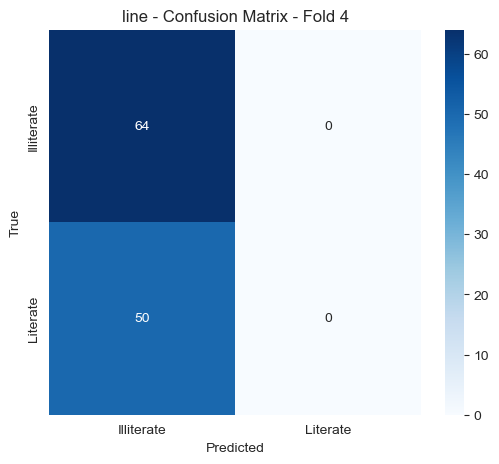

Fold 4 Final Train Acc: 0.5680, Final Val Acc: 0.5614
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.5921 - loss: 153.4452 - val_accuracy: 0.5614 - val_loss: 7.0568
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5987 - loss: 2.8791 - val_accuracy: 0.7281 - val_loss: 0.5263
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9537 - loss: 0.1898 - val_accuracy: 0.6930 - val_loss: 0.5844
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9911 - loss: 0.0517 - val_accuracy: 0.7281 - val_loss: 0.6891
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 0.7456 - val_loss: 0.9266
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.7544 - val_loss: 0.9558
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━

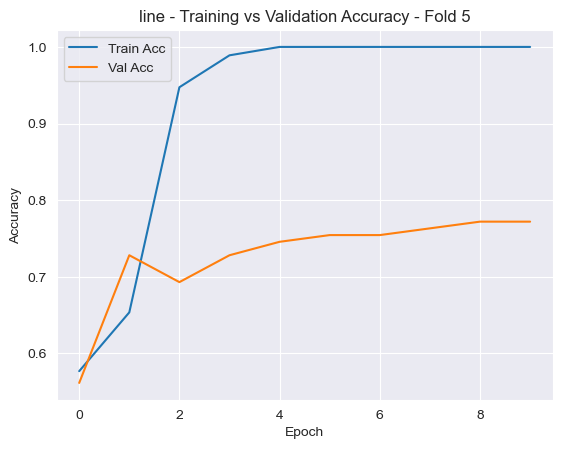

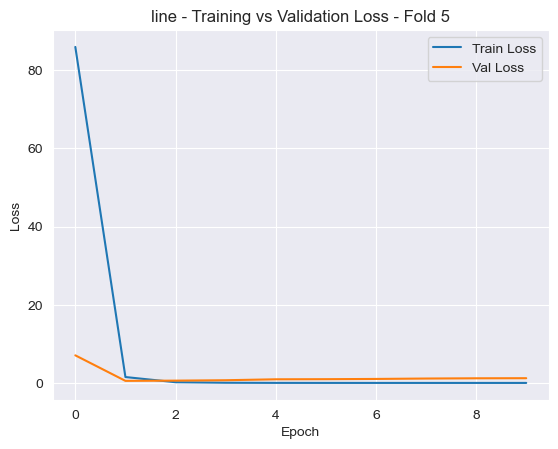

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


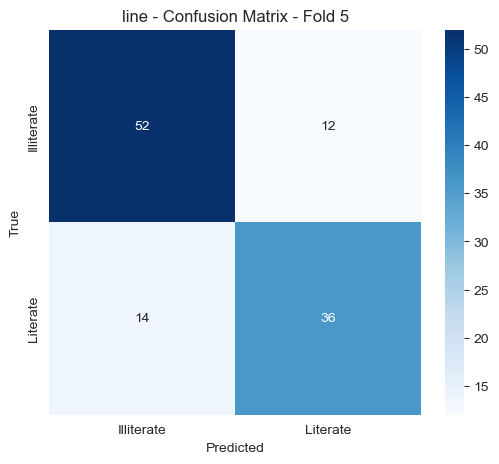

Fold 5 Final Train Acc: 1.0000, Final Val Acc: 0.7719

=== Running 5-fold CV for: pie ===
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4590 - loss: 273.0390 - val_accuracy: 0.4000 - val_loss: 56.7675
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.4869 - loss: 60.9547 - val_accuracy: 0.5000 - val_loss: 1.2095
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.7194 - loss: 0.7111 - val_accuracy: 0.4333 - val_loss: 1.2393
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.8333 - loss: 0.3556 - val_accuracy: 0.5333 - val_loss: 0.7363
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.9565 - loss: 0.1689 - val_accuracy: 0.6667 - val_loss: 0.6371
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9900 - loss: 0.1276 - val_accuracy: 0.7000 - val_loss: 1.0371
Epoch 7/1

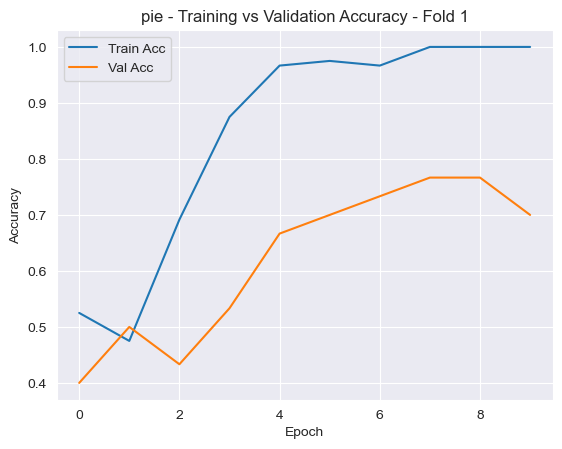

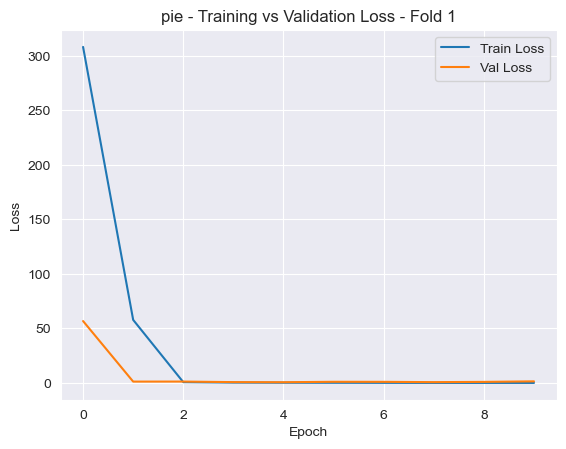

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


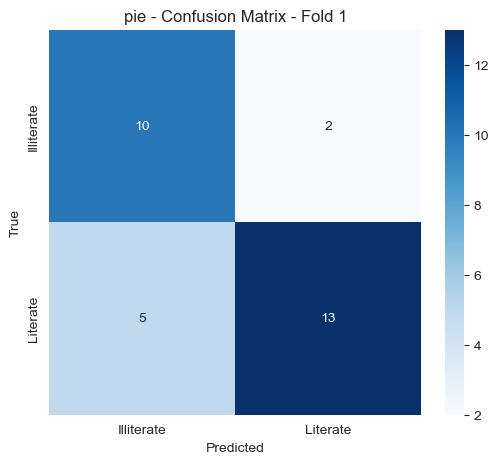

Fold 1 Final Train Acc: 1.0000, Final Val Acc: 0.7000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.5410 - loss: 164.4544 - val_accuracy: 0.4000 - val_loss: 24.9578
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.5381 - loss: 13.5956 - val_accuracy: 0.4000 - val_loss: 6.5256
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.6317 - loss: 1.7606 - val_accuracy: 0.5333 - val_loss: 0.7075
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.9125 - loss: 0.3814 - val_accuracy: 0.6667 - val_loss: 0.6150
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.9860 - loss: 0.2600 - val_accuracy: 0.6333 - val_loss: 0.6215
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.9967 - loss: 0.2219 - val_accuracy: 0.6000 - val_loss: 0.6349
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/

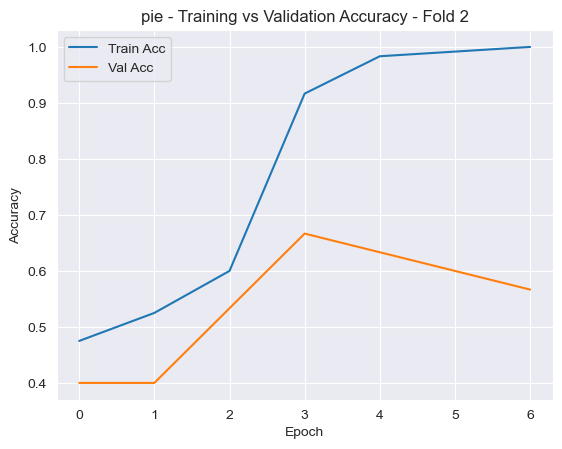

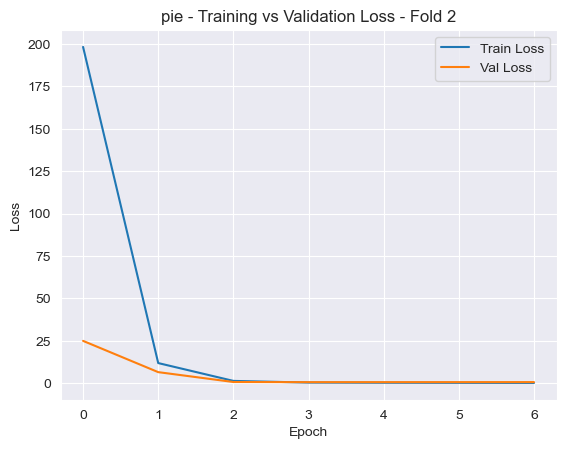

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


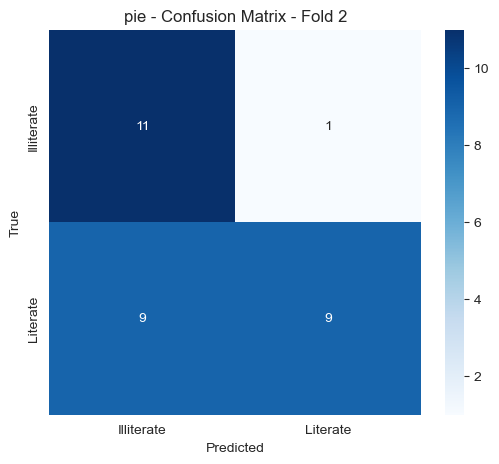

Fold 2 Final Train Acc: 1.0000, Final Val Acc: 0.5667
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.4590 - loss: 666.5669 - val_accuracy: 0.4000 - val_loss: 646.2603
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.5181 - loss: 267.8899 - val_accuracy: 0.4000 - val_loss: 21.6941
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.6517 - loss: 9.3315 - val_accuracy: 0.6000 - val_loss: 0.8711
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.5085 - loss: 1.5691 - val_accuracy: 0.4667 - val_loss: 1.0049
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.7527 - loss: 0.4666 - val_accuracy: 0.5667 - val_loss: 0.7287
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.9269 - loss: 0.2621 - val_accuracy: 0.4333 - val_loss: 1.2202


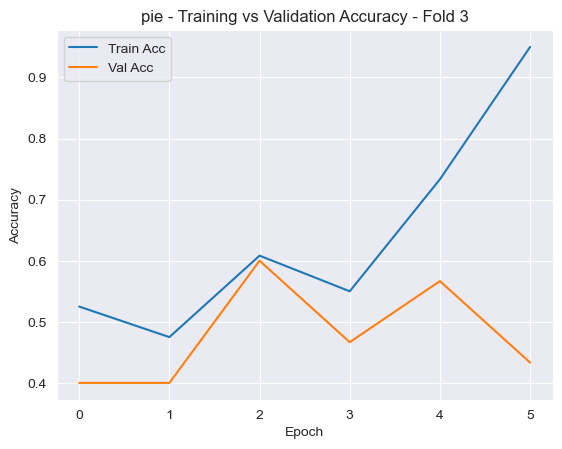

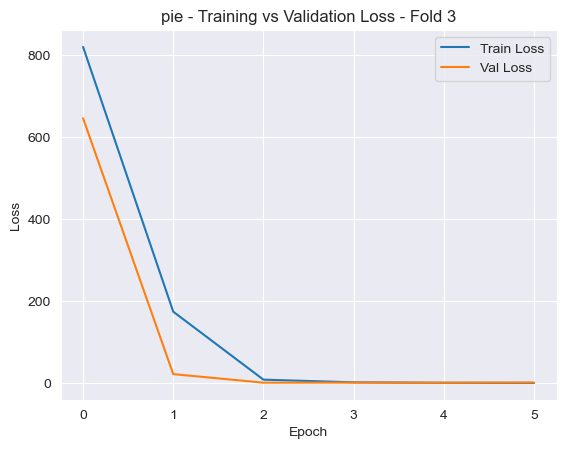

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


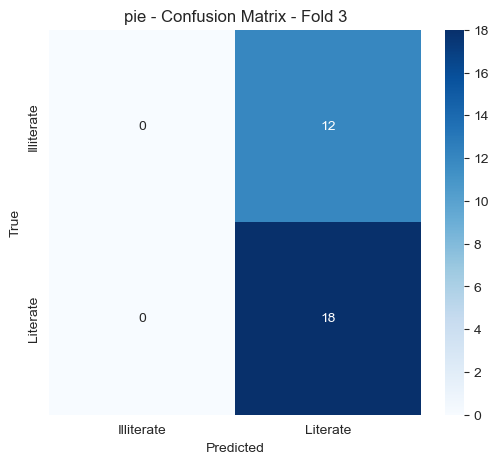

Fold 3 Final Train Acc: 0.9500, Final Val Acc: 0.4333
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.5410 - loss: 484.0693 - val_accuracy: 0.4000 - val_loss: 31.3402
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.5181 - loss: 20.3932 - val_accuracy: 0.4000 - val_loss: 26.9338
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.6517 - loss: 6.2308 - val_accuracy: 0.4000 - val_loss: 0.6934
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.6235 - loss: 0.6928 - val_accuracy: 0.4000 - val_loss: 0.6935


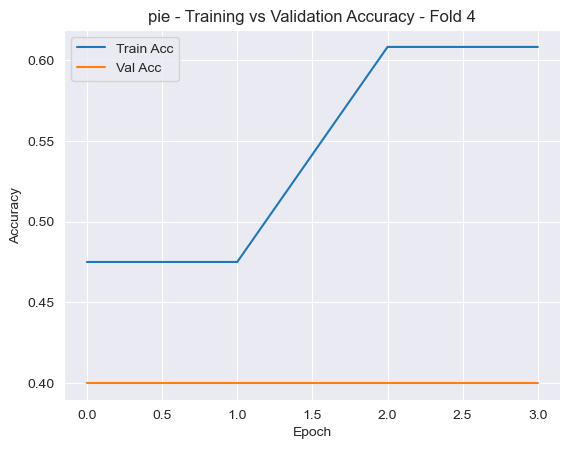

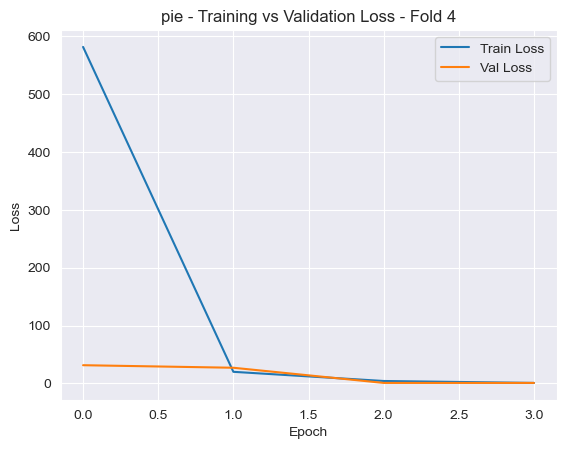

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


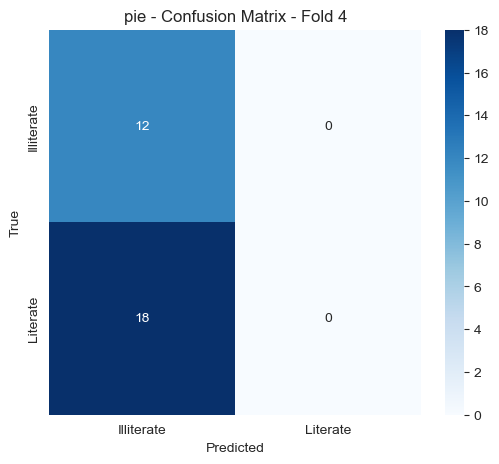

Fold 4 Final Train Acc: 0.6083, Final Val Acc: 0.4000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.4590 - loss: 263.4358 - val_accuracy: 0.4000 - val_loss: 191.5772
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.5181 - loss: 97.0738 - val_accuracy: 0.6000 - val_loss: 45.0561
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.3808 - loss: 49.2466 - val_accuracy: 0.4000 - val_loss: 5.9678
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.5204 - loss: 4.5189 - val_accuracy: 0.4000 - val_loss: 2.2383
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.6587 - loss: 0.7272 - val_accuracy: 0.7000 - val_loss: 0.5752
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.8160 - loss: 0.3801 - val_accuracy: 0.4333 - val_loss: 1.2047
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173

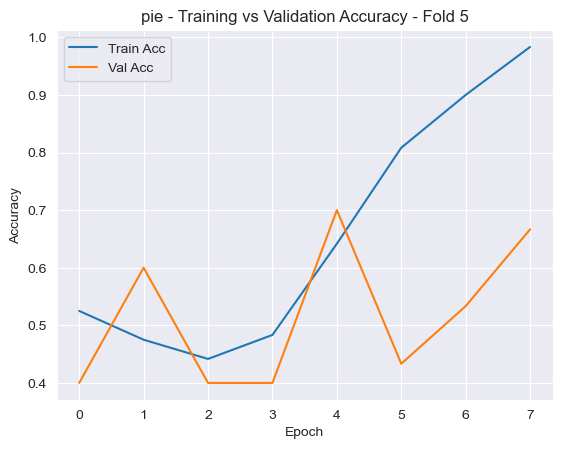

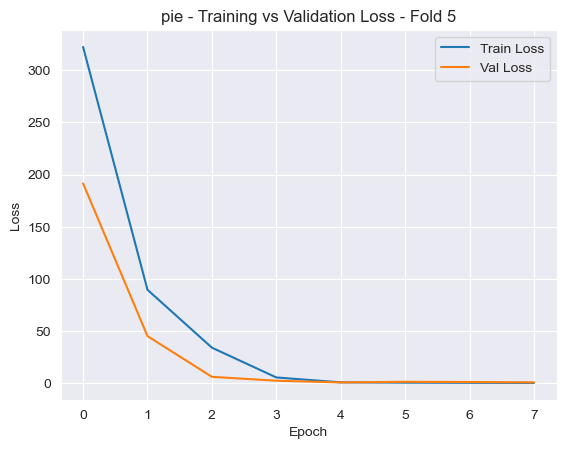

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


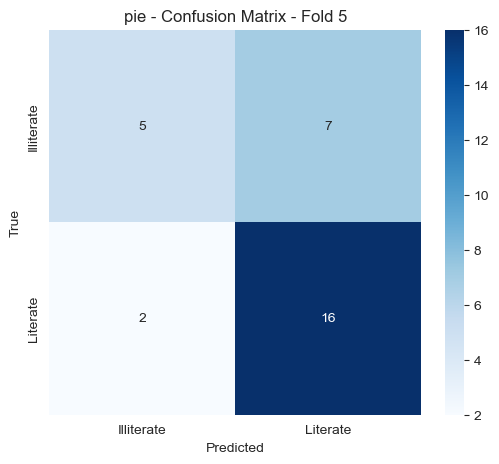

Fold 5 Final Train Acc: 0.9833, Final Val Acc: 0.6667


In [5]:
# Dictionary to hold results per graph type
all_results = {}

# Train and collect results
for dataset_name in ["bar", "line", "pie"]:
    print(f"\n=== Running 5-fold CV for: {dataset_name} ===")
    average_results = {
        "train_accuracies": [],
        "val_accuracies": []
    }

    for fold in range(5):
        train_and_evaluate(dataset_name, fold, average_results)

    # Store the mean results for this dataset
    all_results[dataset_name] = {
        "mean_train": np.mean(average_results["train_accuracies"]),
        "mean_val": np.mean(average_results["val_accuracies"])
    }

In [6]:
# After training all datasets, print summary
print("\n=== Summary of Average Accuracies by Graph Type ===")
for dataset_name, result in all_results.items():
    print(f"\nGraph Type: {dataset_name}")
    print(f"→ Average Train Accuracy: {result['mean_train']:.4f}")
    print(f"→ Average Validation Accuracy: {result['mean_val']:.4f}")


=== Summary of Average Accuracies by Graph Type ===

Graph Type: bar
→ Average Train Accuracy: 0.9135
→ Average Validation Accuracy: 0.6116

Graph Type: line
→ Average Train Accuracy: 0.7408
→ Average Validation Accuracy: 0.6333

Graph Type: pie
→ Average Train Accuracy: 0.9083
→ Average Validation Accuracy: 0.5533
